**Working on Credit File for Histogram, Skwedness.**

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, shapiro, normaltest
df = pd.read_csv("Credit.csv")

In [ ]:
print("Dataset shape:", df.shape)
print(df.head())

Dataset shape: (1000, 14)
  checkin_acc  duration credit_history  amount savings_acc present_emp_since  \
0         A11         6            A34    1169         A65               A75   
1         A12        48            A32    5951         A61               A73   
2         A14        12            A34    2096         A61               A74   
3         A11        42            A32    7882         A61               A74   
4         A11        24            A33    4870         A61               A73   

   inst_rate personal_status  residing_since  age inst_plans  num_credits  \
0          4             A93               4   67       A143            2   
1          2             A92               2   22       A143            1   
2          2             A93               3   49       A143            1   
3          2             A93               4   45       A143            1   
4          3             A93               4   53       A143            2   

    job  status  
0  A173     

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   checkin_acc        1000 non-null   object
 1   duration           1000 non-null   int64 
 2   credit_history     1000 non-null   object
 3   amount             1000 non-null   int64 
 4   savings_acc        1000 non-null   object
 5   present_emp_since  1000 non-null   object
 6   inst_rate          1000 non-null   int64 
 7   personal_status    1000 non-null   object
 8   residing_since     1000 non-null   int64 
 9   age                1000 non-null   int64 
 10  inst_plans         1000 non-null   object
 11  num_credits        1000 non-null   int64 
 12  job                1000 non-null   object
 13  status             1000 non-null   int64 
dtypes: int64(7), object(7)
memory usage: 109.5+ KB


**Here's how you can generate histograms for all numerical columns**

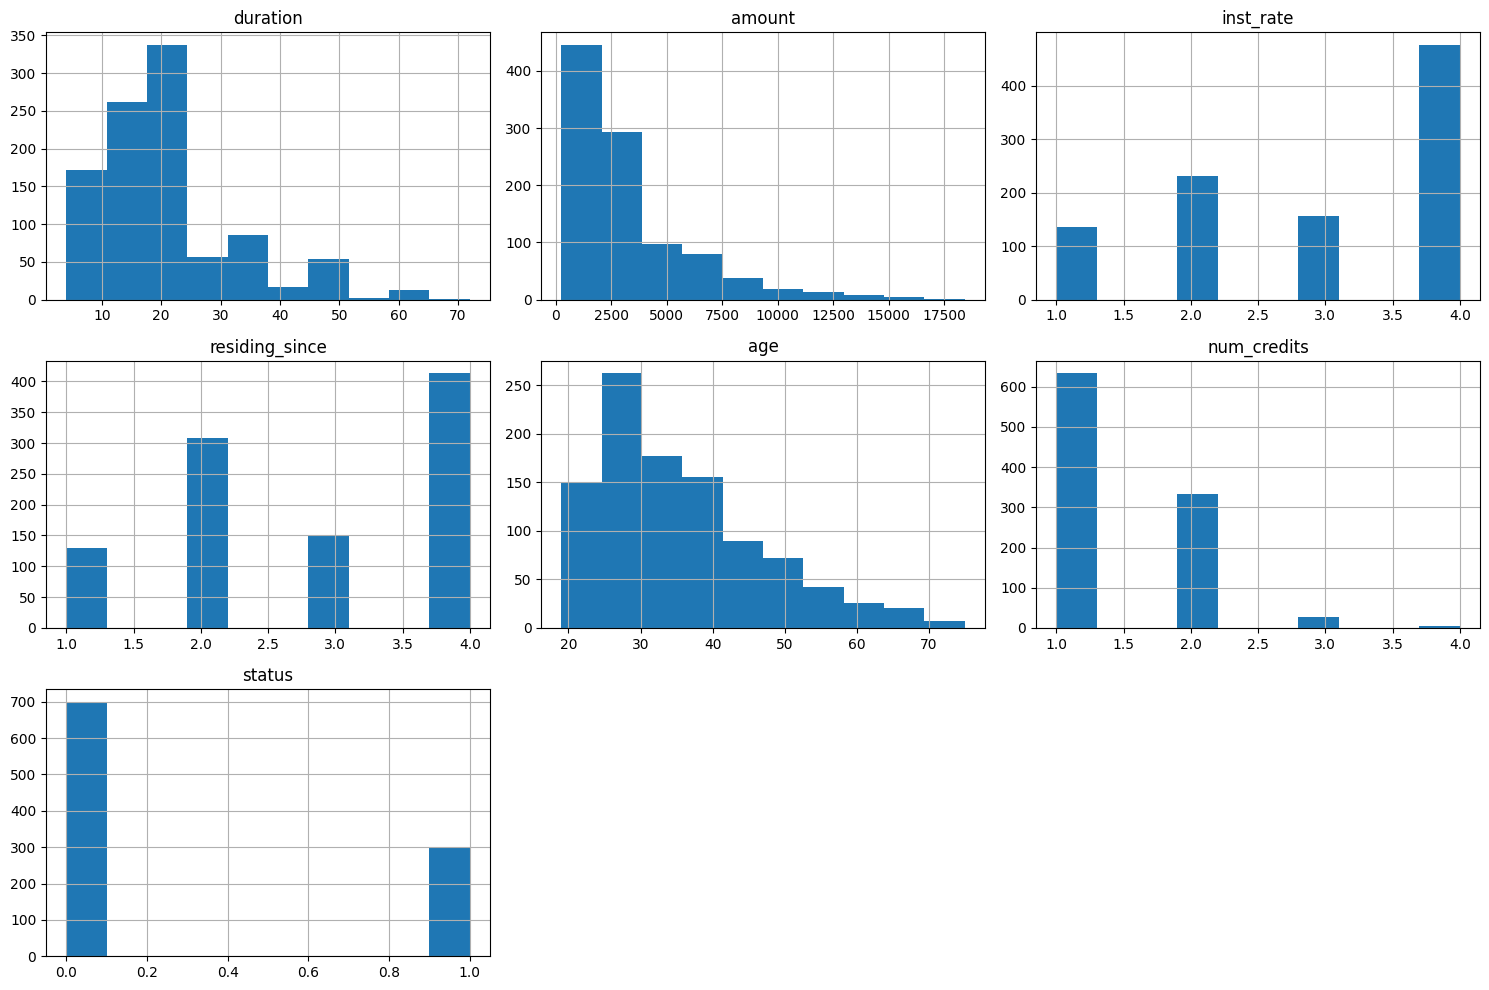

In [ ]:
import matplotlib.pyplot as plt
numerical_cols = df.select_dtypes(include=['number']).columns
df[numerical_cols].hist(figsize=(15, 10))
plt.tight_layout()
plt.show()

**Target as Status**

In [ ]:
# Use value_counts() to find the counts of 0 and 1 in the 'status' column
status_counts = df['status'].value_counts()

# Display the counts
display(status_counts)

,count
status,
0,700
1,300


***Skewness***

In [ ]:
# Calculate the skewness of numerical columns
numerical_cols = df.select_dtypes(include=['number'])
skewness = numerical_cols.skew()

# Display the skewness values
display(skewness)

,0
duration,1.094184
amount,1.949628
inst_rate,-0.531348
residing_since,-0.272570
age,1.020739
num_credits,1.272576
status,0.874183


In [ ]:
# Create the feature matrix by dropping the target variable
x_features = df.drop('status', axis=1)

# Select categorical columns for one-hot encoding
categorical_cols = x_features.select_dtypes(include=['object']).columns

# Apply one-hot encoding to the categorical columns
x_features = pd.get_dummies(x_features, columns=categorical_cols, drop_first=True)

# Display the first few rows of the modified feature matrix
display(x_features.head())

,duration,amount,inst_rate,residing_since,age,num_credits,checkin_acc_A12,checkin_acc_A13,checkin_acc_A14,credit_history_A31,...,present_emp_since_A74,present_emp_since_A75,personal_status_A92,personal_status_A93,personal_status_A94,inst_plans_A142,inst_plans_A143,job_A172,job_A173,job_A174
0,6,1169,4,4,67,2,False,False,False,False,...,False,True,False,True,False,False,True,False,True,False
1,48,5951,2,2,22,1,True,False,False,False,...,False,False,True,False,False,False,True,False,True,False
2,12,2096,2,3,49,1,False,False,True,False,...,True,False,False,True,False,False,True,True,False,False
3,42,7882,2,4,45,1,False,False,False,False,...,True,False,False,True,False,False,True,False,True,False
4,24,4870,3,4,53,2,False,False,False,False,...,False,False,False,True,False,False,True,False,True,False


In [ ]:
def get_significant_vars(lm):
    """
    method get_significant_vars() that takes the model object as an input and returns the list  of significant variables after filtering out the variable with corresponding p-value less than 0.05.
    """

    # Store the p-values and corresponding columns names in a dataframe
    var_p_vals_df = pd.DataFrame(lm.pvalues)
    var_p_vals_df['vars'] = var_p_vals_df.index
    var_p_vals_df.columns = ['pvals', 'vars']
    # Filter the columns names with p-value <= 0.05
    return list(var_p_vals_df[var_p_vals_df.pvals <= 0.05]['vars'])

significant_vars = get_significant_vars(logit_model)
print("Significant variables:", significant_vars)

# Filter significant_vars to include only columns present in x_train
significant_vars_in_xtrain = [var for var in significant_vars if var in x_train.columns]

# Only these features have come out to be significant.
# Note: We need to ensure the 'const' is included if it was significant and is needed for the model
if 'const' in significant_vars_in_xtrain:
    # If 'const' is significant, use the original x_train with selected significant variables
    final_logit = sm.Logit(y_train, x_train[significant_vars_in_xtrain]).fit()
    # For prediction, use x_test with selected significant variables (including const)
    x_test_for_prediction = x_test[significant_vars_in_xtrain]
else:
     # If 'const' is not significant, refit without adding constant again if it was already added
     # Assuming x_train and x_test already have a constant if needed from previous steps
     significant_vars_no_const = [var for var in significant_vars_in_xtrain if var != 'const']
     final_logit = sm.Logit(y_train, x_train[significant_vars_no_const]).fit()
     # For prediction, use x_test with selected significant variables (excluding const)
     x_test_for_prediction = x_test[significant_vars_no_const]


y_pred_df = pd.DataFrame({"actual": y_test,
                         "predicted_prob": final_logit.predict(x_test_for_prediction)})

display(y_pred_df.head())

Significant variables: ['duration', 'amount', 'inst_rate', 'age', 'checkin_acc_A12', 'checkin_acc_A13', 'checkin_acc_A14', 'credit_history_A34', 'savings_acc_A65', 'inst_plans_A143']
Optimization terminated successfully.
         Current function value: 0.627354
         Iterations 5


,actual,predicted_prob
521,1,0.382298
737,0,0.327457
740,0,0.382298
660,0,0.327457
411,0,0.327457


In [ ]:
# Store skewness values less than 0.5 in a variable
skewness_less_than_0_5 = skewness[skewness < 0.5]

# Display the new variable
display(skewness_less_than_0_5)

,0
inst_rate,-0.531348
residing_since,-0.272570


In [ ]:
import statsmodels.api as sm
from sklearn.model_selection import train_test_split

# Select only the columns with skewness less than 0.5 from the original DataFrame
features_less_skewed = df[skewness_less_than_0_5.index]

# Define the target variable
y = df['status']

# Add a constant for the intercept
x = sm.add_constant(features_less_skewed)

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42) # 80/20 split

# Fit the logistic regression model
logit_model_less_skewed = sm.Logit(y_train, x_train).fit()

# Display the model summary
print(logit_model_less_skewed.summary2())

Optimization terminated successfully.
         Current function value: 0.610872
         Iterations 5
                        Results: Logit
Model:              Logit            Method:           MLE     
Dependent Variable: status           Pseudo R-squared: 0.002   
Date:               2025-09-27 04:48 AIC:              983.3950
No. Observations:   800              BIC:              997.4489
Df Model:           2                Log-Likelihood:   -488.70 
Df Residuals:       797              LL-Null:          -489.54 
Converged:          1.0000           LLR p-value:      0.43246 
No. Iterations:     5.0000           Scale:            1.0000  
---------------------------------------------------------------
                 Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
---------------------------------------------------------------
const           -1.1522   0.2959 -3.8939 0.0001 -1.7321 -0.5722
inst_rate        0.0875   0.0696  1.2578 0.2085 -0.0489  0.2239
residing_since   0.0173   0